In [1]:
import os.path

import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyam
from fair.forward import fair_scm
from scmdata import ScmRun, run_append
from tqdm import tqdm_notebook

import openscm_runner
from openscm_runner.run import run
from openscm_runner.adapters import FAIR

<IPython.core.display.Javascript object>

/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_runner/run.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
openscm_runner.__version__

'0.4.4'

In [3]:
fair = FAIR()
fair.get_version()

'1.6.2'

In [4]:
with open('../data_output_large/fair-samples/fair-1.6.2-wg3-params.json') as f:
    config_list = json.load(f)

In [5]:
# what a pain

species = [
'Emissions|BC',
'Emissions|CH4',
'Emissions|CO',
'Emissions|CO2|MAGICC AFOLU',
'Emissions|CO2|MAGICC Fossil and Industrial',
'Emissions|F-Gases|HFC|HFC125',
'Emissions|F-Gases|HFC|HFC134a',
'Emissions|F-Gases|HFC|HFC143a',
'Emissions|F-Gases|HFC|HFC227ea',
'Emissions|F-Gases|HFC|HFC23',
'Emissions|F-Gases|HFC|HFC245fa',
'Emissions|F-Gases|HFC|HFC32',
'Emissions|F-Gases|HFC|HFC4310mee',
'Emissions|F-Gases|PFC|C2F6',
'Emissions|F-Gases|PFC|C6F14',
'Emissions|F-Gases|PFC|CF4',
'Emissions|F-Gases|SF6',
'Emissions|Montreal Gases|CCl4',
'Emissions|Montreal Gases|CFC|CFC11',
'Emissions|Montreal Gases|CFC|CFC113',
'Emissions|Montreal Gases|CFC|CFC114',
'Emissions|Montreal Gases|CFC|CFC115',
'Emissions|Montreal Gases|CFC|CFC12',
'Emissions|Montreal Gases|CH3Br',
'Emissions|Montreal Gases|CH3CCl3',
'Emissions|Montreal Gases|CH3Cl',
'Emissions|Montreal Gases|HCFC141b',
'Emissions|Montreal Gases|HCFC142b',
'Emissions|Montreal Gases|HCFC22',
'Emissions|Montreal Gases|Halon1202',
'Emissions|Montreal Gases|Halon1211',
'Emissions|Montreal Gases|Halon1301',
'Emissions|Montreal Gases|Halon2402',
'Emissions|N2O',
'Emissions|NH3',
'Emissions|NOx',
'Emissions|OC',
'Emissions|Sulfur',
'Emissions|VOC']

In [6]:
df_fair = ScmRun('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv', lowercase_cols=True)
df_fair.filter(
    scenario=['ssp119','ssp126','ssp245','ssp370','ssp434','ssp460','ssp534-over','ssp585'], 
#    year=range(2015,2301),
    year=range(2015,2101),
    variable=species,
    region='World', 
    inplace=True
)
print(len(df_fair))
#df_fair.head(50)

312


In [7]:
nt = df_fair.time_points.years()[-1] - 1750 + 1
nt

351

In [8]:
# # add in natural emissions and natural forcing
# ch4_n2o_df = pd.read_csv('../data/cmip6_natural_ch4_n2o.csv')
# ch4_n2o = ch4_n2o_df.values[:nt,1:]
# sol_vol_df = pd.read_csv('../data/cmip6_natural_forcing.csv')
# solar_forcing = sol_vol_df.values[:nt,1]
# volcanic_forcing = sol_vol_df.values[:nt,2]

In [9]:
#config_list[0]

In [10]:
# convert lists to numpy arrays
updated_config = []
for i in range(len(config_list)):
    updated_config.append({})
    for key, value in config_list[i].items():
        if type(value)==list:
            updated_config[i][key] = np.asarray(value)
        else:
            updated_config[i][key] = value
#     updated_config[i]['endyear'] = 2300
#     updated_config[i]['natural'] = ch4_n2o
#     updated_config[i]['F_solar'] = solar_forcing
#     updated_config[i]['F_volcanic'] = volcanic_forcing

In [11]:
# need parallel FaIR in openscm-runner

x = run(
    climate_models_cfgs={
        "FAIR": updated_config,
    },
    scenarios=df_fair,
    output_variables=(
        "Surface Temperature",
        "Surface Temperature (GMST)",
        "Atmospheric Concentrations|CO2",
        "Atmospheric Concentrations|CH4",
        "Atmospheric Concentrations|N2O",
        "Effective Radiative Forcing",
        "Effective Radiative Forcing|CO2",
        "Effective Radiative Forcing|CH4",
        "Effective Radiative Forcing|N2O",
        "Effective Radiative Forcing|Greenhouse Gases",
        "Effective Radiative Forcing|Aerosols",
        "Effective Radiative Forcing|Aerosols|Direct Effect|BC",
        "Effective Radiative Forcing|Aerosols|Direct Effect|OC",
        "Effective Radiative Forcing|Aerosols|Direct Effect|Sulfur",
        "Effective Radiative Forcing|Aerosols|Direct Effect|Nitrate",
        "Effective Radiative Forcing|Aerosols|Direct Effect",
        "Effective Radiative Forcing|Aerosols|Indirect Effect",
        "Heat Uptake",
        "Heat Uptake|Ocean",
        "Airborne Fraction",
    ),
)

In [12]:
# convert to ScmRun for better plotting functionality
x = ScmRun(x.timeseries())

In [13]:
x.tail()

time                                                                                                                   1750-01-01  \
climate_model model         region run_id scenario unit          variable                                                           
FaIRv1.6.2    REMIND-MAGPIE World  16631  ssp585   W/m**2        Effective Radiative Forcing|Aerosols|Direct Effect  3.691132e-10   
                                                                 Effective Radiative Forcing|Aerosols|Indirect E...  5.625770e-10   
                                                   J/yr          Heat Uptake                                         4.948493e+21   
                                                                 Heat Uptake|Ocean                                   4.552614e+21   
                                                   dimensionless Airborne Fraction                                   0.000000e+00   

time                                                                                                                   1751-01-01  \
climate_model model         region run_id scenario unit          variable                                                           
FaIRv1.6.2    REMIND-MAGPIE World  16631  ssp585   W/m**2        Effective Radiative Forcing|Aerosols|Direct Effect  3.579332e-04   
                                                                 Effective Radiative Forcing|Aerosols|Indirect E...  3.549192e-03   
                                                   J/yr          Heat Uptake                                         3.719075e+21   
                                                                 Heat Uptake|Ocean                                   3.421549e+21   
                                                   dimensionless Airborne Fraction                                   8.205176e-01   

time                                                                                                                   1752-01-01  \
climate_model model         region run_id scenario unit          variable                                                           
FaIRv1.6.2    REMIND-MAGPIE World  16631  ssp585   W/m**2        Effective Radiative Forcing|Aerosols|Direct Effect  7.647580e-04   
                                                                 Effective Radiative Forcing|Aerosols|Indirect E...  5.529608e-03   
                                                   J/yr          Heat Uptake                                         2.607687e+21   
                                                                 Heat Uptake|Ocean                                   2.399072e+21   
                                                   dimensionless Airborne Fraction                                   7.555686e-01   

time                                                                                                                   1753-01-01  \
climate_model model         region run_id scenario unit          variable                                                           
FaIRv1.6.2    REMIND-MAGPIE World  16631  ssp585   W/m**2        Effective Radiative Forcing|Aerosols|Direct Effect  2.710394e-04   
                                                                 Effective Radiative Forcing|Aerosols|Indirect E...  3.613197e-03   
                                                   J/yr          Heat Uptake                                         1.629792e+21   
                                                                 Heat Uptake|Ocean                                   1.499409e+21   
                                                   dimensionless Airborne Fraction                                   7.178032e-01   

time                                                                                                                   1754-01-01  \
climate_model model         region run_id scenario unit          variable                                                           
FaIRv1

In [14]:
def new_timeseries(
    n=100,
    count=1,
    model="example",
    scenario="ssp119",
    variable="Surface Temperature",
    unit="K",
    region="World",
    cls=ScmRun,
    **kwargs,
):
    data = np.random.rand(n, count) * np.arange(n)[:, np.newaxis]
    index = 2000 + np.arange(n)
    return cls(
        data,
        columns={
            "model": model,
            "scenario": scenario,
            "variable": variable,
            "region": region,
            "unit": unit,
            **kwargs,
        },
        index=index,
    )

In [15]:
# save output to netCDF
x.to_nc('../data_output_large/fair-samples/ssp_emissions_driven_runs.nc', dimensions=["run_id", "scenario", "model"])

In [16]:
x = ScmRun.from_nc('../data_output_large/fair-samples/ssp_emissions_driven_runs.nc')

from scmdata.plotting import RCMIP_SCENARIO_COLOURS

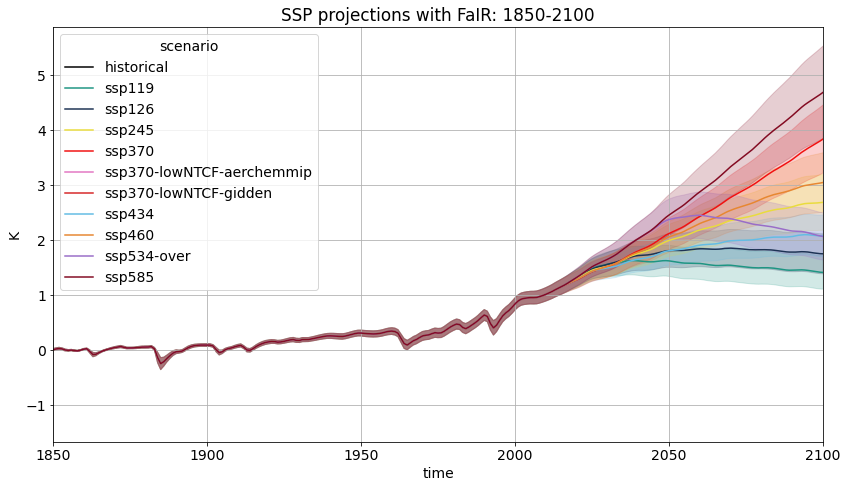

In [34]:
plt.rcParams['font.size'] = 14
ax = plt.figure(figsize=(12, 7)).add_subplot(111)
# x.filter(variable="Surface Temperature").relative_to_ref_period_mean(year=range(1985,2005)).lineplot(
#     hue="scenario", style="model", ax=ax, time_axis="year", palette=RCMIP_SCENARIO_COLOURS,
#     hue_order=RCMIP_SCENARIO_COLOURS.keys(),
# )
x.filter(variable="Surface Temperature").relative_to_ref_period_mean(year=range(1850,1900)).lineplot(
    hue="scenario",
    ax=ax,
    time_axis="year",
    palette=RCMIP_SCENARIO_COLOURS,
    hue_order=RCMIP_SCENARIO_COLOURS.keys(),
)
ax.set_xlim(1850,2100)
#ax.axhline(0, color='k', ls=':')
ax.grid()
ax.set_title('SSP projections with FaIR: 1850-2100')
plt.tight_layout()

<AxesSubplot:xlabel='time', ylabel='W/m**2'>

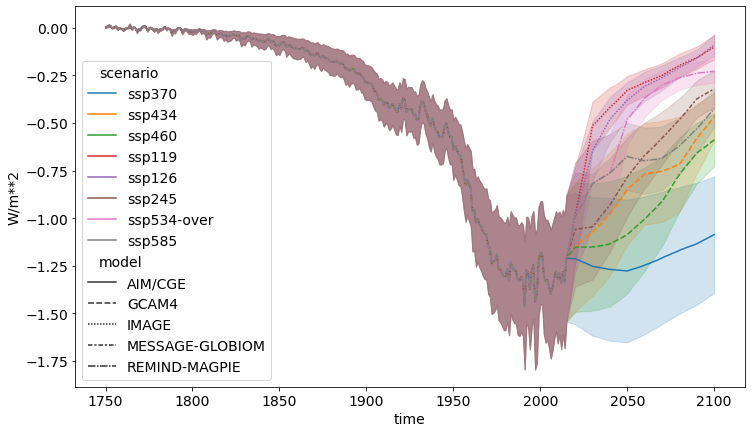

In [19]:
ax = plt.figure(figsize=(12, 7)).add_subplot(111)
x.filter(variable="Effective Radiative Forcing|Aerosols").lineplot(
    hue="scenario", style="model", ax=ax, time_axis="year"
)

<AxesSubplot:xlabel='time', ylabel='W/m**2'>

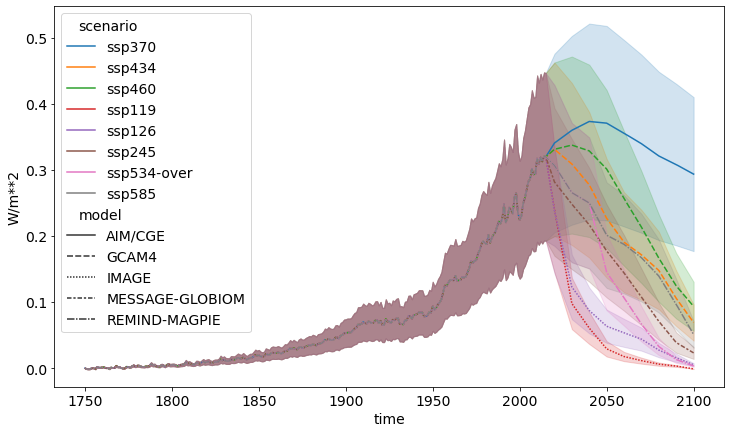

In [20]:
ax = plt.figure(figsize=(12, 7)).add_subplot(111)
x.filter(variable="Effective Radiative Forcing|Aerosols|Direct Effect|BC").lineplot(
    hue="scenario", style="model", ax=ax, time_axis="year"
)

<AxesSubplot:xlabel='time', ylabel='W/m**2'>

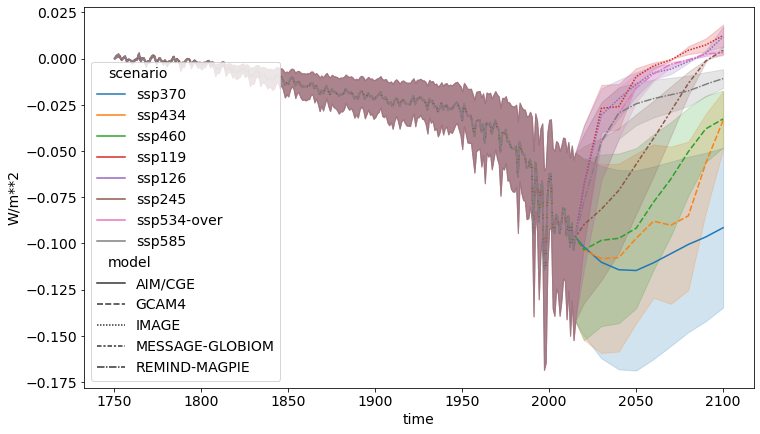

In [21]:
ax = plt.figure(figsize=(12, 7)).add_subplot(111)
x.filter(variable="Effective Radiative Forcing|Aerosols|Direct Effect|OC").lineplot(
    hue="scenario", style="model", ax=ax, time_axis="year"
)

<AxesSubplot:xlabel='time', ylabel='W/m**2'>

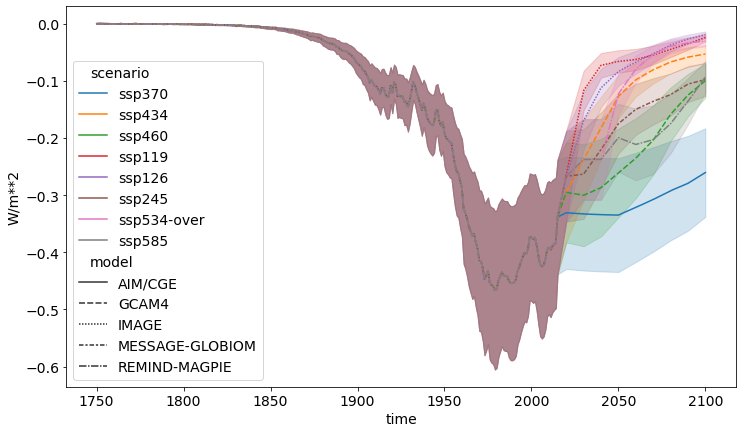

In [22]:
ax = plt.figure(figsize=(12, 7)).add_subplot(111)
x.filter(variable="Effective Radiative Forcing|Aerosols|Direct Effect|Sulfur").lineplot(
    hue="scenario", style="model", ax=ax, time_axis="year"
)

<AxesSubplot:xlabel='time', ylabel='W/m**2'>

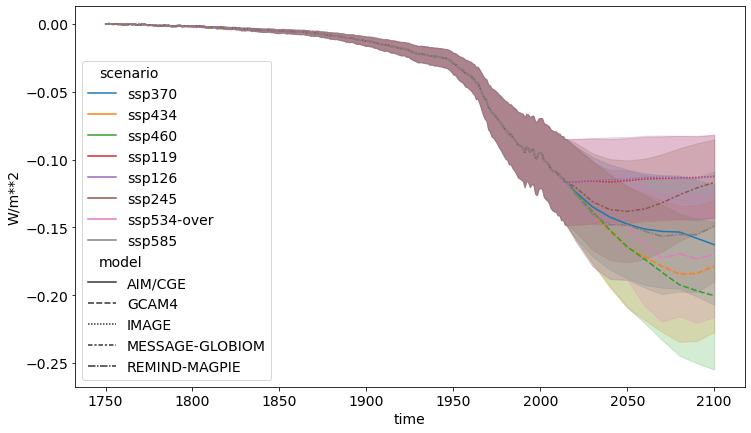

In [23]:
ax = plt.figure(figsize=(12, 7)).add_subplot(111)
x.filter(variable="Effective Radiative Forcing|Aerosols|Direct Effect|Nitrate").lineplot(
    hue="scenario", style="model", ax=ax, time_axis="year"
)

<AxesSubplot:xlabel='time', ylabel='W/m**2'>

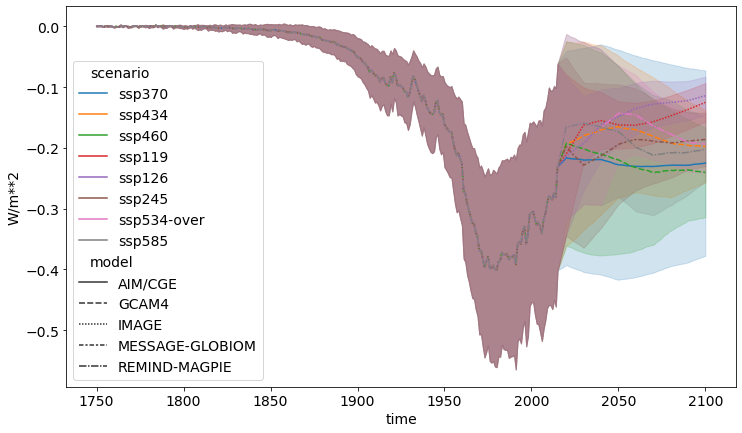

In [24]:
ax = plt.figure(figsize=(12, 7)).add_subplot(111)
x.filter(variable="Effective Radiative Forcing|Aerosols|Direct Effect").lineplot(
    hue="scenario", style="model", ax=ax, time_axis="year"
)

<AxesSubplot:xlabel='time', ylabel='W/m**2'>

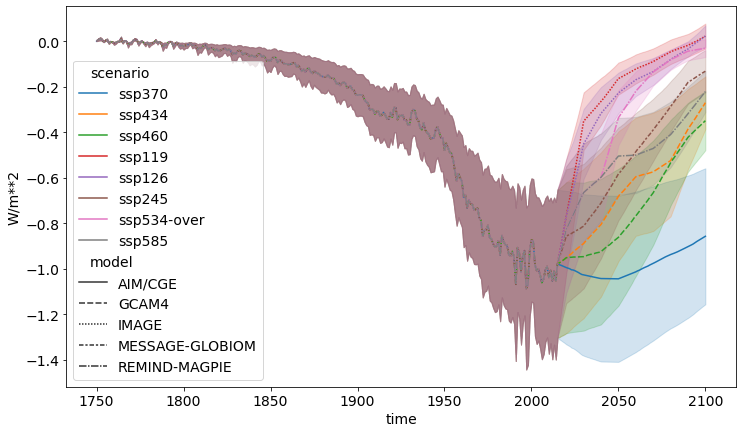

In [25]:
ax = plt.figure(figsize=(12, 7)).add_subplot(111)
x.filter(variable="Effective Radiative Forcing|Aerosols|Indirect Effect").lineplot(
    hue="scenario", style="model", ax=ax, time_axis="year"
)

<AxesSubplot:xlabel='time', ylabel='ppm'>

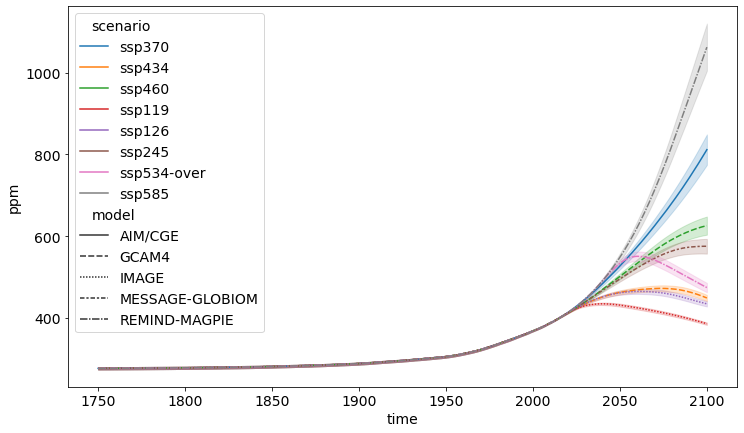

In [26]:
ax = plt.figure(figsize=(12, 7)).add_subplot(111)
x.filter(variable="Atmospheric Concentrations|CO2").lineplot(
    hue="scenario", style="model", ax=ax, time_axis="year"
)

<AxesSubplot:xlabel='time', ylabel='ppb'>

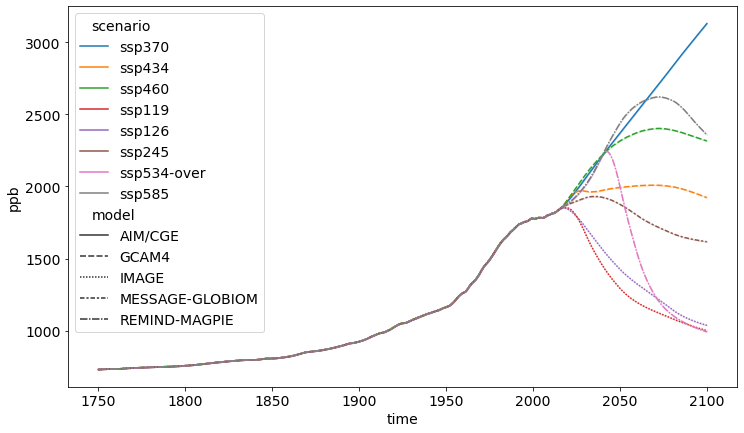

In [27]:
ax = plt.figure(figsize=(12, 7)).add_subplot(111)
x.filter(variable="Atmospheric Concentrations|CH4").lineplot(
    hue="scenario", style="model", ax=ax, time_axis="year"
)

<AxesSubplot:xlabel='time', ylabel='ppb'>

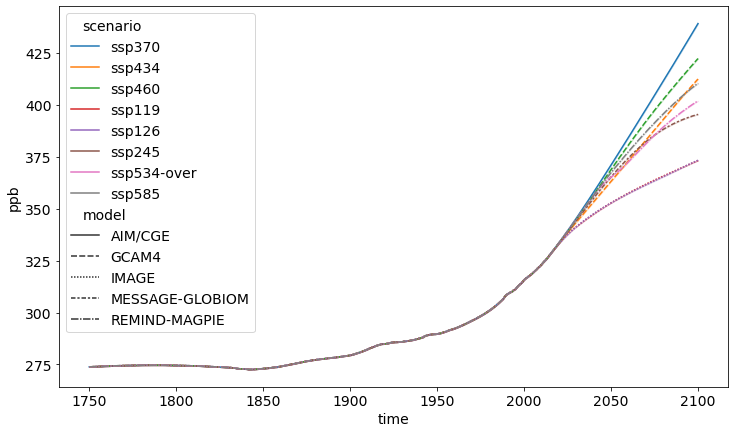

In [28]:
ax = plt.figure(figsize=(12, 7)).add_subplot(111)
x.filter(variable="Atmospheric Concentrations|N2O").lineplot(
    hue="scenario", style="model", ax=ax, time_axis="year"
)

<AxesSubplot:xlabel='time', ylabel='J/yr'>

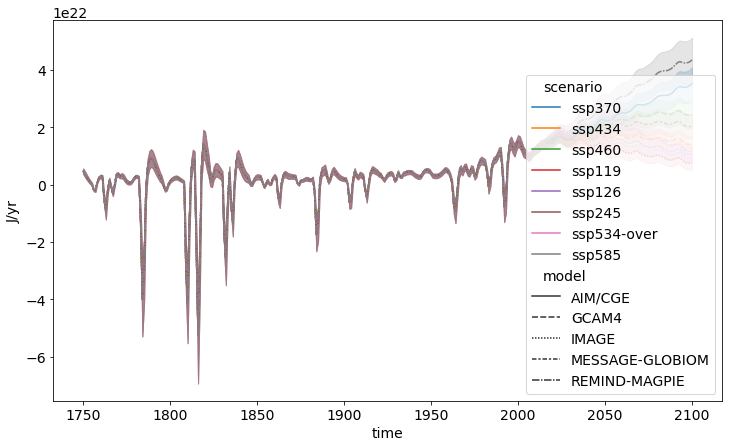

In [29]:
ax = plt.figure(figsize=(12, 7)).add_subplot(111)
x.filter(variable="Heat Uptake").lineplot(
    hue="scenario", style="model", ax=ax, time_axis="year"
)

<AxesSubplot:xlabel='time', ylabel='dimensionless'>

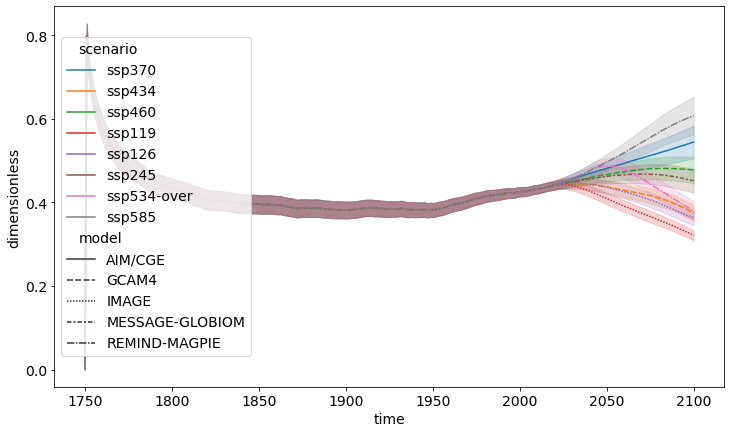

In [30]:
ax = plt.figure(figsize=(12, 7)).add_subplot(111)
x.filter(variable="Airborne Fraction").lineplot(
    hue="scenario", style="model", ax=ax, time_axis="year"
)

In [31]:
x.filter(scenario='ssp119', variable="Atmospheric Concentrations|CO2").timeseries()

time                                                                            1750-01-01  \
climate_model model region run_id scenario unit variable                                     
FaIRv1.6.2    IMAGE World  0      ssp119   ppm  Atmospheric Concentrations|CO2  273.229589   
                           1      ssp119   ppm  Atmospheric Concentrations|CO2  279.882800   
                           2      ssp119   ppm  Atmospheric Concentrations|CO2  274.068587   
                           3      ssp119   ppm  Atmospheric Concentrations|CO2  276.298444   
                           4      ssp119   ppm  Atmospheric Concentrations|CO2  276.218129   
...                                                                                    ...   
                           2074   ssp119   ppm  Atmospheric Concentrations|CO2  278.705064   
                           2075   ssp119   ppm  Atmospheric Concentrations|CO2  273.199019   
                           2076   ssp119   ppm  Atmospheric Concentrations|CO2  278.174655   
                           2077   ssp119   ppm  Atmospheric Concentrations|CO2  279.649578   
                           2078   ssp119   ppm  Atmospheric Concentrations|CO2  277.355897   

time                                                                            1751-01-01  \
climate_model model region run_id scenario unit variable                                     
FaIRv1.6.2    IMAGE World  0      ssp119   ppm  Atmospheric Concentrations|CO2  273.241909   
                           1      ssp119   ppm  Atmospheric Concentrations|CO2  279.894121   
                           2      ssp119   ppm  Atmospheric Concentrations|CO2  274.081776   
                           3      ssp119   ppm  Atmospheric Concentrations|CO2  276.309973   
                           4      ssp119   ppm  Atmospheric Concentrations|CO2  276.229056   
...                                                                                    ...   
                           2074   ssp119   ppm  Atmospheric Concentrations|CO2  278.715392   
                           2075   ssp119   ppm  Atmospheric Concentrations|CO2  273.211057   
                           2076   ssp119   ppm  Atmospheric Concentrations|CO2  278.184635   
                           2077   ssp119   ppm  Atmospheric Concentrations|CO2  279.662533   
                           2078   ssp119   ppm  Atmospheric Concentrations|CO2  277.368789   

time                                                                            1752-01-01  \
climate_model model region run_id scenario unit variable                                     
FaIRv1.6.2    IMAGE World  0      ssp119   ppm  Atmospheric Concentrations|CO2  273.266711   
                           1      ssp119   ppm  Atmospheric Concentrations|CO2  279.917436   
                           2      ssp119   ppm  Atmospheric Concentrations|CO2  274.107933   
                           3      ssp119   ppm  Atmospheric Concentrations|CO2  276.333630   
                           4      ssp119   ppm  Atmospheric Concentrations|CO2  276.251789   
...                                                                                    ...   
                           2074   ssp119   ppm  Atmospheric Concentrations|CO2  278.737320   
                           2075   ssp119   ppm  Atmospheric Concentrations|CO2  273.235451   
                           2076   ssp119   ppm  Atmospheric Concentrations|CO2  278.206025   
                           2077   ssp119   ppm  Atmospheric Concentrations|CO2  279.688333   
                           2078   ssp119   ppm  Atmospheric Concentrations|CO2  277.394495   

time                                                                            1753-01-01  \
climate_model model region run_id scenario unit variable                                     
FaIRv1.6.2    IMAGE World  0      ssp119   ppm  Atmospheric Concentrations|CO2  273.291509   
                           1      ssp119   ppm  A

In [32]:
x.filter(variable="Atmospheric Concentrations|N2O", scenario='ssp119', run_id=0).timeseries().values.squeeze()[264]

326.97706689529565

In [33]:
x.filter(variable="Atmospheric Concentrations|CH4", scenario='ssp119', run_id=0).timeseries().values.squeeze()[264]

1831.4709981235555